# Creating a Multi-Output Architecture
***
In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an `Energy Efficiency dataset` which uses the bulding features (e.g. wall area, roof area) as inputs and has `two outputs`: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

### Attribute Information
***
The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.

####Specifically
***

- X1 Relative Compactness
- X2 Surface Area
- X3 Wall Area
- X4 Roof Area
- X5 Overall Height
- X6 Orientation
- X7 Glazing Area
- X8 Glazing Area Distribution
- y1 Heating Load
- y2 Cooling Load

### Imports
***

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.vis_utils import plot_model

### Utilities
***

In [2]:
def format_output(data):

  y1 = data.pop('Y1')
  y1 = np.array(y1)
  y2 = data.pop('Y2')
  y2 = np.array(y2)

  return y1, y2

In [3]:
def norm(x):
  
  return (x- train_stats['mean']) / train_stats['std']

In [21]:
def plot_diff(y_true, y_pred, title=''):

  plt.scatter(y_true, y_pred)
  plt.title(title)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 100], [-100, 100])
  plt.show()

  return None

In [26]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

### Prepare the data
***

In [6]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

df = pd.read_excel(url)
df.sample(frac=1).reset_index(drop=True)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.86,588.0,294.0,147.00,7.0,5,0.40,4,32.75,31.00
1,0.98,514.5,294.0,110.25,7.0,4,0.40,3,32.23,33.86
2,0.98,514.5,294.0,110.25,7.0,2,0.00,0,15.55,21.33
3,0.90,563.5,318.5,122.50,7.0,5,0.40,5,35.24,37.27
4,0.66,759.5,318.5,220.50,3.5,4,0.25,3,12.74,16.14
...,...,...,...,...,...,...,...,...,...,...
763,0.90,563.5,318.5,122.50,7.0,2,0.00,0,20.84,28.28
764,0.82,612.5,318.5,147.00,7.0,2,0.25,2,25.74,28.27
765,0.71,710.5,269.5,220.50,3.5,4,0.10,4,10.53,13.79
766,0.64,784.0,343.0,220.50,3.5,2,0.40,4,19.06,21.68


In [7]:
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

In [8]:
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()

In [9]:
train_Y = format_output(train)
test_Y = format_output(test)

In [10]:
norm_train_X = norm(train)
norm_test_X = norm(test)

### Build the model
***

In [11]:
def model_multi_output():
  input_layer = Input(shape=(len(train.columns),))
  first_dense = Dense(units=128, activation=tf.nn.relu)(input_layer)
  second_dense = Dense(units=128, activation=tf.nn.relu)(first_dense)

  y1_output = Dense(units=1, name='y1_output')(second_dense)
  third_dense = Dense(units=64, activation=tf.nn.relu)(second_dense)

  y2_output = Dense(units=1, name='y2_output')(third_dense)

  model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

  return model

In [12]:
model = model_multi_output()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

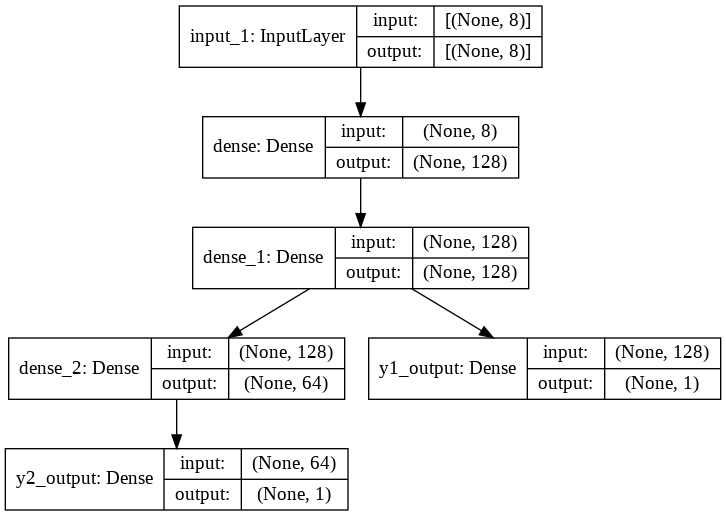

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

### Configure parameters
***

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss={'y1_output':'mse', 'y2_output':'mse'},
              metrics = {'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                         'y2_output': tf.keras.metrics.RootMeanSquaredError()})

### Train the model
***

In [17]:
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10,
                    validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 6ms/step - loss: 249.7726 - y1_output_loss: 119.7954 - y2_output_loss: 129.9771 - y1_output_root_mean_squared_error: 10.9451 - y2_output_root_mean_squared_error: 11.4008 - val_loss: 28.9414 - val_y1_output_loss: 12.2076 - val_y2_output_loss: 16.7338 - val_y1_output_root_mean_squared_error: 3.4939 - val_y2_output_root_mean_squared_error: 4.0907
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 36.2076 - y1_output_loss: 13.3219 - y2_output_loss: 22.8857 - y1_output_root_mean_squared_error: 3.6499 - y2_output_root_mean_squared_error: 4.7839 - val_loss: 30.9234 - val_y1_output_loss: 12.6136 - val_y2_output_loss: 18.3098 - val_y1_output_root_mean_squared_error: 3.5516 - val_y2_output_root_mean_squared_error: 4.2790
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 27.6527 - y1_output_loss: 10.5153 - y2_output_loss: 17.1375 - y1_output_root_mean_squared_error: 3.2427 - y2_output_root_mean_sq

### Evaluate the model and plot metrics
***

In [18]:
loss, y1_loss, y2_loss, y1_rmse, y2_rmse = model.evaluate(norm_test_X, test_Y)

5/5 [==============================] - 0s 4ms/step - loss: 0.6979 - y1_output_loss: 0.1812 - y2_output_loss: 0.5167 - y1_output_root_mean_squared_error: 0.4257 - y2_output_root_mean_squared_error: 0.7188


In [19]:
print('loss: {}\ny1_loss: {}\ny2_loss: {}\ny1_rmse: {}\ny2_rmse: {}'.format(loss, y1_loss, y2_loss, y1_rmse, y2_rmse))

loss: 0.6978529691696167
y1_loss: 0.18118329346179962
y2_loss: 0.516669750213623
y1_rmse: 0.4256563186645508
y2_rmse: 0.7187974452972412


In [20]:
y_pred = model.predict(norm_test_X)

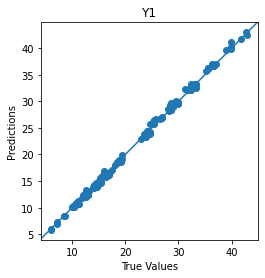

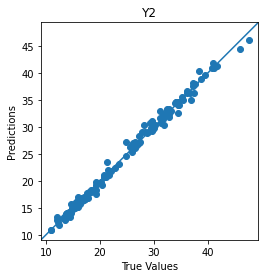

In [22]:
plot_diff(test_Y[0], y_pred[0], title='Y1')
plot_diff(test_Y[1], y_pred[1], title='Y2')

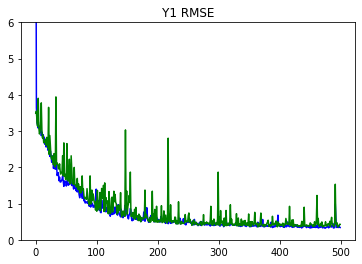

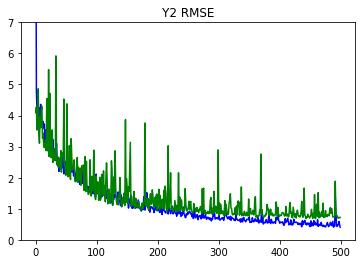

In [27]:
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)